In [2]:
# !pip install IPython
from IPython.display import Image

In [ ]:
!git clone https://github.com/Im-JihyunKim/2023_LG_ES_SSL_2.git # colab 사용시

-----------------------

# [Self-supervised Learning] SimSiam
## Simple Siamese

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 모듈 불러오기

In [1]:
import os, random
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader, Subset  # Dataset과 dataloader를 기반으로 미니배치 학습, 데이터 셔플, 병렬 처리까지 간단하게 수행 가능하도록 지원
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [3]:
'''
seed 정의
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 2. Custom Dataset 정의
- 방대한 데이터를 batch 단위로 쪼개서 불러올 수 있도록 정의해주는 과정 (기존에는 모든 데이터셋을 한꺼번에 처리)
- Custom Dataset은 가변 길이 input이나 batch를 만들어줄 때 필요  
- 본 튜토리얼에서는 증강된 이미지도 함께 불러와야 하기에 이를 가져올 수 있는 Custom Dataset을 정의할 것임  
cf. https://didu-story.tistory.com/85

### CIFAR10 Dataset

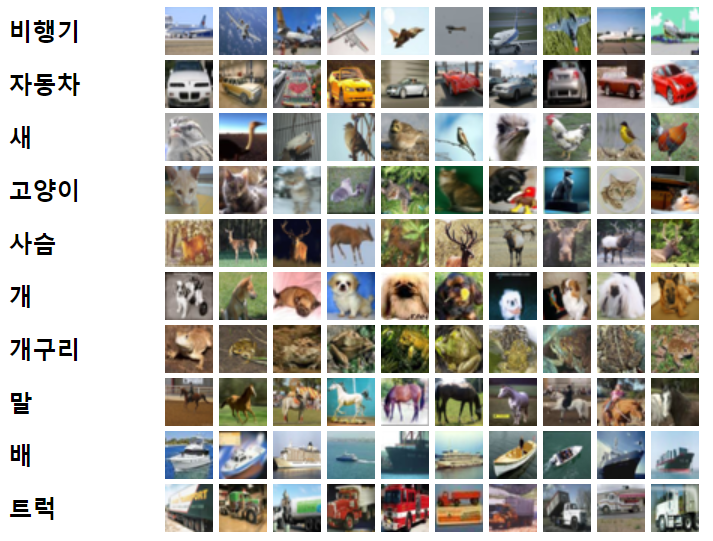

In [7]:
Image('image/cifar10.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/cifar10.PNG') # colab 사용시

- 32x32의 RGB 이미지로 구성된 데이터셋
  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 50,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 따로 지정하지 않음)
- 10개의 class를 분류하는 image classification task에 주로 활용

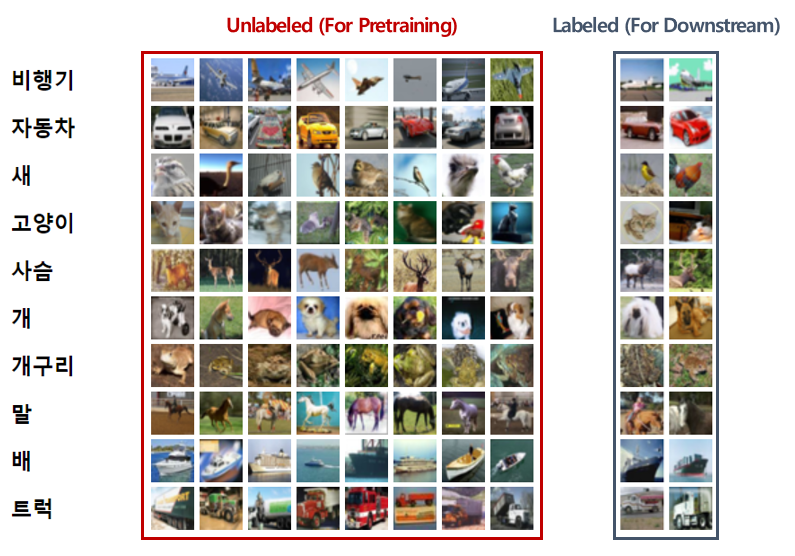

In [8]:
Image('image/Cifar10_dataset.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/Cifar10_dataset.PNG') # colab 사용시

In [4]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir:str):
        self.data_dir = data_dir

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)


    # For BYOL : BYOL 사전학습 시 사용되는 데이터셋
    def get_pretrain_dataset(self):
        pretrain_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=MultiViewGenerator(  # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                 base_transforms=self.get_transform(size=32)),  # 사전에 정의한 이미지 변형 방법 적용
                                             download=True)
        return pretrain_dataset
    
    # For Downstream task : Downstream 지도학습에 사용되는 데이터
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=2023)

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        

    @staticmethod 
    def get_transform(size: int=32, s:int=1):
        """
        Return a set of data augmentation transformations 
        as MoCo v2's which is similar to SimCLR https://arxiv.org/abs/2002.05709
        """
        normalize = transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010)
        )
        color_jitter = transforms.ColorJitter(0.4 * s,   # not strengthened
                                              0.4 * s,
                                              0.4 * s,
                                              0.1 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms
    

########################################################################################################################################

class MultiViewGenerator(object):
    """
    Take two random crops of one image as the query and key.
    """
    def __init__(self, base_transforms):
        self.transforms = base_transforms
    
    def __call__(self, x):
        output1 = self.transforms(x)
        output2 = self.transforms(x)
        
        output = [output1, output2]
        
        return output

## 3. SimSiam 네트워크 정의
* Online/Target Network : ResNet
* Predictor : MLP

__SimSiam__
- BYOL과 동일하게 positive pair만을 고려한 방법론
- BYOL과 동일하게 Online network의 가중치만 업데이트
  - 다만 EMA 업데이트가 아닌, 일정 주기마다 network의 가중치를 그대로 복사
- BYOL과 다르게 동일한 구조의 네트워크를 이용 (구조적 제약 없음)
* Siamese Neural Network! (구조가 닮았으며 더 나아가 weight를 공유)

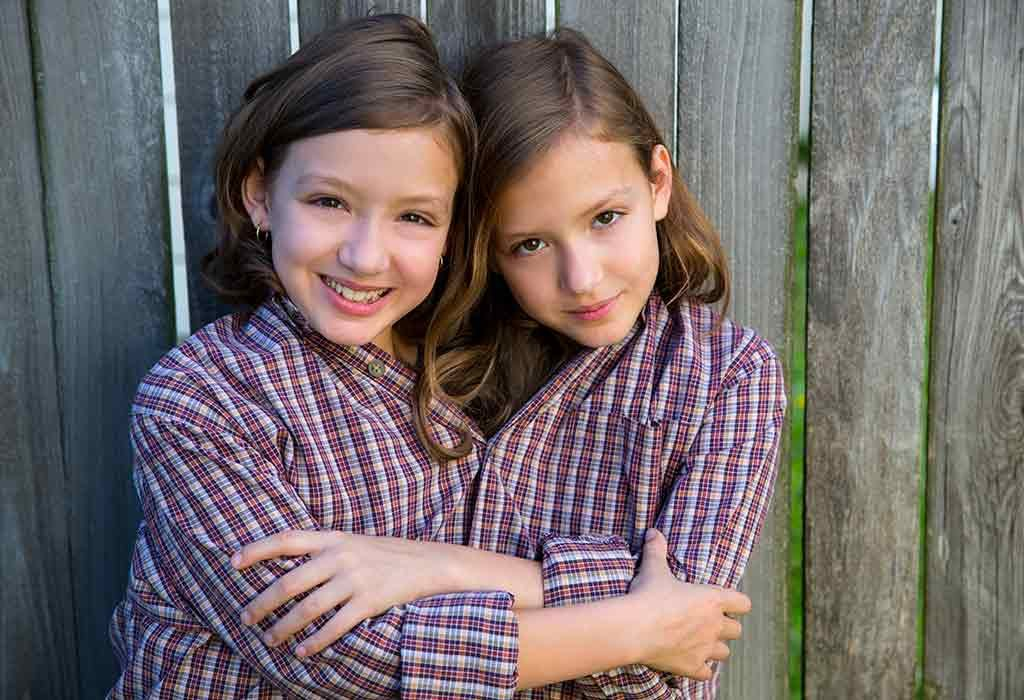

In [4]:
Image('image/simsiam_twins.jpg') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/simsiam_twins.jpg') # colab 사용시

In [5]:
class ResNet(nn.Module):
    def __init__(self, base_model: str, hidden_size: int, projection_size: int):
        super(ResNet, self).__init__()

        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   # ResNet layer 개수에 따라 다른 backbone 선정
            'resnet50': models.resnet50(pretrained=False)
        }

        resnet = self.get_basemodel(base_model)

        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Predictor
        self.projection = projection(resnet.fc.in_features, hidden_size, projection_size)
        
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
        
        model = self.resnet_dict[model_name]
        
        return model

######################################################################################################

class projection(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size: int):
        super(projection, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size, bias=False), 
            nn.BatchNorm1d(mlp_hidden_size),
            nn.ReLU(inplace=True),
            # nn.Linear(mlp_hidden_size, mlp_hidden_size, bias=False),
            # nn.BatchNorm1d(mlp_hidden_size),
            # nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size, bias=False),
            nn.BatchNorm1d(projection_size, affine=False)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

#######################################################################################################

class prediction(nn.Module):  # bottelneck structure
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size: int):
        super(prediction, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size, bias=False), 
            nn.BatchNorm1d(mlp_hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size, bias=False)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

## 4. SimSiam 학습 정의

### SimSiam 모델 학습 방식
- Online predictor와 Target projector에서 출력된 벡터 간 코사인 유사도를 구한 뒤, negative를 취해줌
- BYOL과 마찬가지로 augmentation 조합을 바꾸어 loss를 2번 계산 후 더해준 값으로 최종 loss를 구함

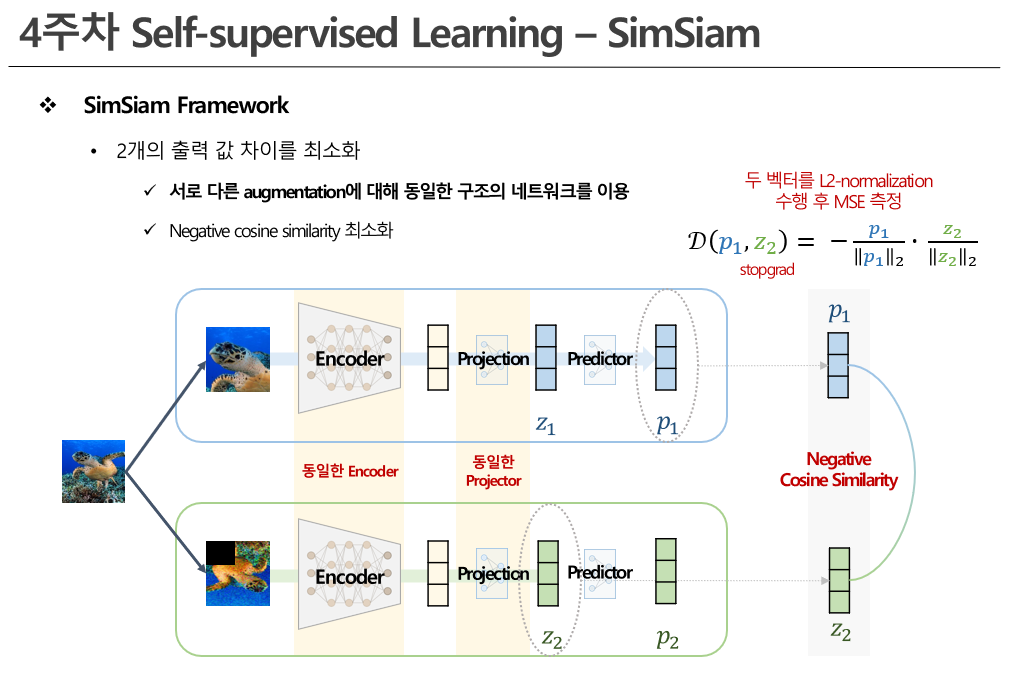

In [5]:
Image('image/simsiam1.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/simsiam1.PNG') # colab 사용시

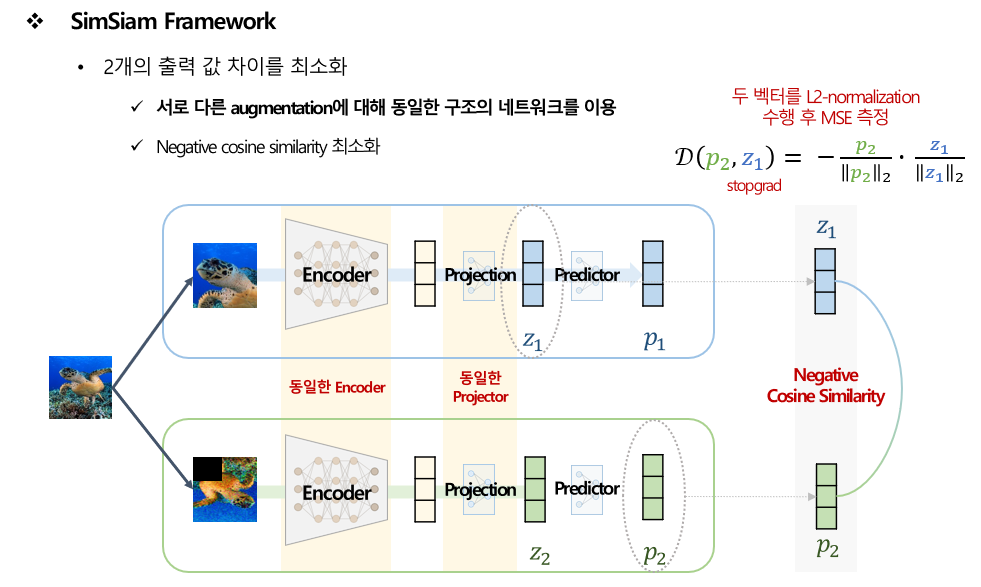

In [6]:
Image('image/simsiam2.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/simsiam2.PNG') # colab 사용시

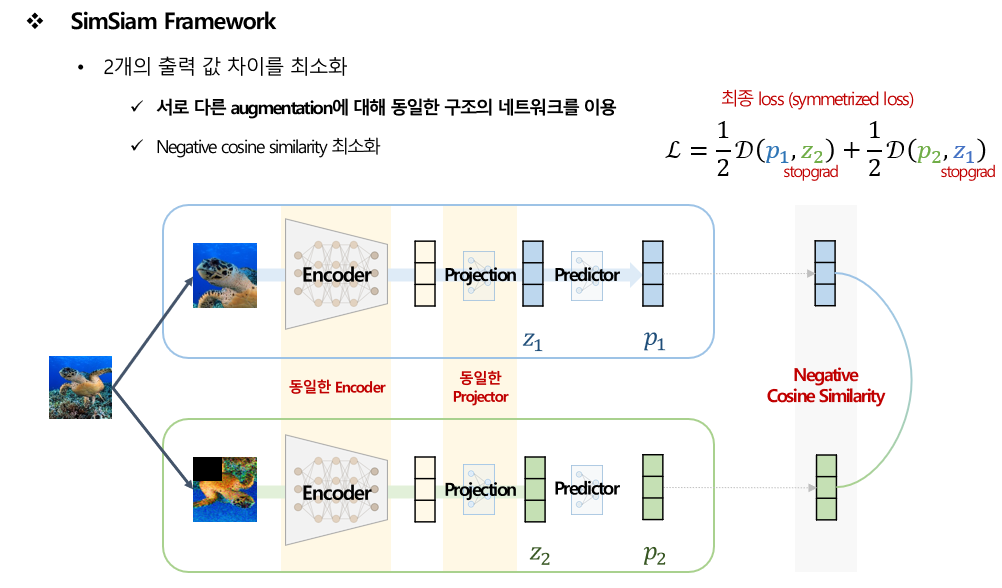

In [7]:
Image('image/simsiam3.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/simsiam3.PNG') # colab 사용시

In [7]:
class SimSiam_Trainer(object):
    def __init__(self, device, model, predictor,
                 **kwargs):
        self.device = device

        self.model = model.to(self.device)          # backbone(encoder) + projection
        self.predictor = predictor.to(self.device)  # predictor

        self.criterion = nn.CosineSimilarity(dim=1).to(self.device)

        self.__dict__.update(kwargs)
    
    def pretrain(self, train_loader):
        # make checkpoint directory
        os.makedirs(self.ckpt_dir, exist_ok=True)

        n_iter = 0
        for epoch in range(self.epochs):
            train_loss = 0

            for (img_aug_1, img_aug_2), _ in tqdm(train_loader):
                img_aug_1 = img_aug_1.to(self.device)
                img_aug_2 = img_aug_2.to(self.device)

                """
                loss:
                Extract features with the backbone and applies the projection head and prediction head
                to the output space. If both batch_view_1 and batch_view_2 are not None, both will be passed through the backbone, projection,
                and prediction head. If batch_view_2 is None, only batch_view_1 will be forwarded.

                See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
                """
                z1 = self.model(img_aug_1).detach()  # stop gradient
                z2 = self.model(img_aug_2).detach()  # stop gradient
                p1, p2 = self.predictor(z1), self.predictor(z2)
                
                # negative cosine sim loss
                # -> vector를 L2 normalization 한 후 MSE를 측정한 것과 동일
                loss = -(self.criterion(p1, z2).mean() + self.criterion(p2, z1).mean()) / 2

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss
                
                if n_iter % self.logging_steps == 0:
                    print(f'Loss: {loss} \n')
                
                n_iter += 1
            
            train_loss /= (len(train_loader))
            
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n')
        
        # Save the model
        torch.save(self.model.state_dict(), os.path.join(self.ckpt_dir, 'pretrained_SimSiam.pt'))

        return self.model

## SimSiam 코드 실행

In [8]:
def main(device, configs: dict):

    # define dataset, dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir'])   # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'

    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)

    # definde model, optimizer, learning rate scheduler
    model = ResNet(
        base_model=configs['backbone'],
        hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size']
    )

    predictor = prediction(
        in_channels=configs['projection_size'],
        mlp_hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size'])
    
    optim_params = list(model.parameters()) + list(predictor.parameters())
    optimizer = torch.optim.Adam(
        optim_params, 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])

    trainer = SimSiam_Trainer(
        model=model,
        predictor=predictor,
        device=device,
        optimizer=optimizer,
        batch_size = configs['batch_size'],
        epochs = configs['epochs'],
        logging_steps = configs['logging_steps'],
        ckpt_dir = configs['ckpt_dir']
        )
        
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'data_dir': './data/',           # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'
               'ckpt_dir':'./ckpt_dir/SimSiam', # local: './ckpt_dir/SimSiam' or colab:'/content/2023_LG_ES_SSL_2/ckpt_dir/SimSiam'
               'batch_size': 256, 'epochs': 5, 'logging_steps': 20, 
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    
    pretrained_model = main(device, configs)

Files already downloaded and verified


  1%|          | 1/195 [00:03<12:01,  3.72s/it]

Loss: -4.558032378554344e-05 



 11%|█         | 21/195 [00:18<02:08,  1.35it/s]

Loss: -0.07340239733457565 



 21%|██        | 41/195 [00:33<01:54,  1.34it/s]

Loss: -0.07424235343933105 



 31%|███▏      | 61/195 [00:48<01:39,  1.35it/s]

Loss: -0.07878220826387405 



 42%|████▏     | 81/195 [01:03<01:30,  1.27it/s]

Loss: -0.09670906513929367 



 52%|█████▏    | 101/195 [01:23<01:19,  1.18it/s]

Loss: -0.09262105077505112 



 62%|██████▏   | 121/195 [01:38<00:56,  1.32it/s]

Loss: -0.10554693639278412 



 72%|███████▏  | 141/195 [01:54<00:41,  1.29it/s]

Loss: -0.12453784793615341 



 83%|████████▎ | 161/195 [02:09<00:25,  1.32it/s]

Loss: -0.09554874897003174 



 93%|█████████▎| 181/195 [02:24<00:10,  1.31it/s]

Loss: -0.10287763923406601 



100%|██████████| 195/195 [02:35<00:00,  1.26it/s]


Epoch: 1 
Loss: -0.09098666906356812 



  3%|▎         | 6/195 [00:04<02:27,  1.28it/s]

Loss: -0.11088314652442932 



 13%|█▎        | 26/195 [00:20<02:08,  1.31it/s]

Loss: -0.12104149907827377 



 24%|██▎       | 46/195 [00:35<01:53,  1.31it/s]

Loss: -0.11687080562114716 



 34%|███▍      | 66/195 [00:50<01:37,  1.32it/s]

Loss: -0.10338525474071503 



 44%|████▍     | 86/195 [01:05<01:21,  1.34it/s]

Loss: -0.11354035139083862 



 54%|█████▍    | 106/195 [01:20<01:07,  1.32it/s]

Loss: -0.11384382843971252 



 65%|██████▍   | 126/195 [01:35<00:52,  1.30it/s]

Loss: -0.1310109943151474 



 75%|███████▍  | 146/195 [01:51<00:37,  1.30it/s]

Loss: -0.1168464720249176 



 85%|████████▌ | 166/195 [02:06<00:21,  1.32it/s]

Loss: -0.12251880764961243 



 95%|█████████▌| 186/195 [02:21<00:06,  1.35it/s]

Loss: -0.09950501471757889 



100%|██████████| 195/195 [02:28<00:00,  1.31it/s]


Epoch: 2 
Loss: -0.1134043037891388 



  6%|▌         | 11/195 [00:08<02:19,  1.32it/s]

Loss: -0.11840514838695526 



 16%|█▌        | 31/195 [00:23<02:08,  1.28it/s]

Loss: -0.13718768954277039 



 26%|██▌       | 51/195 [00:39<01:49,  1.32it/s]

Loss: -0.1359533965587616 



 36%|███▋      | 71/195 [00:54<01:32,  1.35it/s]

Loss: -0.12190243601799011 



 47%|████▋     | 91/195 [01:09<01:20,  1.29it/s]

Loss: -0.11755399405956268 



 57%|█████▋    | 111/195 [01:25<01:03,  1.32it/s]

Loss: -0.10003329813480377 



 67%|██████▋   | 131/195 [01:40<00:48,  1.31it/s]

Loss: -0.1116674393415451 



 77%|███████▋  | 151/195 [01:55<00:33,  1.33it/s]

Loss: -0.12171302735805511 



 88%|████████▊ | 171/195 [02:10<00:18,  1.31it/s]

Loss: -0.09401387721300125 



 98%|█████████▊| 191/195 [02:25<00:02,  1.35it/s]

Loss: -0.12535886466503143 



100%|██████████| 195/195 [02:28<00:00,  1.31it/s]


Epoch: 3 
Loss: -0.11712563037872314 



  8%|▊         | 16/195 [00:11<02:12,  1.35it/s]

Loss: -0.10887748003005981 



 18%|█▊        | 36/195 [00:27<02:00,  1.31it/s]

Loss: -0.11721818894147873 



 29%|██▊       | 56/195 [00:42<01:44,  1.33it/s]

Loss: -0.1368585079908371 



 39%|███▉      | 76/195 [00:57<01:28,  1.34it/s]

Loss: -0.12304409593343735 



 49%|████▉     | 96/195 [01:12<01:15,  1.31it/s]

Loss: -0.11918878555297852 



 59%|█████▉    | 116/195 [01:27<00:59,  1.32it/s]

Loss: -0.11700178682804108 



 70%|██████▉   | 136/195 [01:42<00:43,  1.34it/s]

Loss: -0.12704403698444366 



 80%|████████  | 156/195 [01:57<00:29,  1.33it/s]

Loss: -0.11803381145000458 



 90%|█████████ | 176/195 [02:12<00:14,  1.35it/s]

Loss: -0.11307365447282791 



100%|██████████| 195/195 [02:27<00:00,  1.33it/s]


Epoch: 4 
Loss: -0.11973285675048828 



  1%|          | 1/195 [00:00<02:26,  1.32it/s]

Loss: -0.1340043842792511 



 11%|█         | 21/195 [00:15<02:11,  1.32it/s]

Loss: -0.10869526863098145 



 21%|██        | 41/195 [00:31<01:56,  1.32it/s]

Loss: -0.10986226797103882 



 31%|███▏      | 61/195 [00:46<01:41,  1.32it/s]

Loss: -0.11887603253126144 



 42%|████▏     | 81/195 [01:01<01:32,  1.23it/s]

Loss: -0.12670859694480896 



 52%|█████▏    | 101/195 [01:17<01:11,  1.31it/s]

Loss: -0.12206830084323883 



 62%|██████▏   | 121/195 [01:32<00:57,  1.28it/s]

Loss: -0.11587782204151154 



 72%|███████▏  | 141/195 [01:48<00:41,  1.32it/s]

Loss: -0.13289883732795715 



 83%|████████▎ | 161/195 [02:03<00:25,  1.31it/s]

Loss: -0.10978378355503082 



 93%|█████████▎| 181/195 [02:18<00:10,  1.28it/s]

Loss: -0.13109377026557922 



100%|██████████| 195/195 [02:29<00:00,  1.31it/s]

Epoch: 5 
Loss: -0.12065054476261139 



## SimSiam으로 사전 학습한 인코더를 사용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [9]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    """
    Computes the accuracy over the top k predictions
    for the specified values of k
    - Top-1 Accuracy: softmax의 output에서 제일 높은 수치(confidence)를 가지는 확률 값이 실제 정답일 경우에 대한 지표 계산
    - Top-n Accuracy : softmax output 중 상위 n개의 확률 값을 가지는 클래스 중 실제 정답이 있는 경우에 대한 지표 계산
    """
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [10]:
class Downstream(object):
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device

        self.encoder = encoder.to(device)   # 사전학습 된 encoder 불러오기
        self.classifier = classifier.to(device)
        self.optimizer = optimizer

        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                # Freeze Encoder Parameters (사전학습된 인코더의 파라미터는 업데이트 하지 않음)
                if self.downstream:
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else:
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            # Test
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
        
        return self.encoder, self.classifier

In [11]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader   
    Cifar10_dataset = CIFAR10Dataset(data_dir=configs['data_dir'])  # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
        # load pretrained encoder
    model = ResNet(
                    base_model=configs['backbone'],
                    hidden_size=configs['hidden_size'],
                    projection_size=configs['projection_size']
                    )
    model.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_SimSiam.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=model.encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',          # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'
               'ckpt_dir':'./ckpt_dir/SimSiam', # local: './ckpt_dir/SimSiam' or colab:'/content/2023_LG_ES_SSL_2/ckpt_dir/SimSiam'
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.3823091983795166 
Top1 Train Accuracy: 11.41357421875 
Top1 Test Accuracy: 13.577974319458008 
Top5 Test Accuracy: 60.509315490722656 

Epoch: 2 
Loss: 2.2390639781951904 
Top1 Train Accuracy: 16.796875 
Top1 Test Accuracy: 17.149940490722656 
Top5 Test Accuracy: 67.48422241210938 

Epoch: 3 
Loss: 2.1529340744018555 
Top1 Train Accuracy: 20.56884765625 
Top1 Test Accuracy: 19.04296875 
Top5 Test Accuracy: 70.068359375 

Epoch: 4 
Loss: 2.0971617698669434 
Top1 Train Accuracy: 22.83935546875 
Top1 Test Accuracy: 21.79987907409668 
Top5 Test Accuracy: 73.193359375 

Epoch: 5 
Loss: 2.050510883331299 
Top1 Train Accuracy: 25.25634765625 
Top1 Test Accuracy: 23.114482879638672 
Top5 Test Accuracy: 74.99248504638672 

Epoch: 6 
Loss: 2.0107016563415527 
Top1 Train Accuracy: 27.001953125 
Top1 Test Accuracy: 23.820613861083984 
Top5 Test Accuracy: 75.88642120361328 

E

------

### 성능 비교

|   | Supervised Learning | SimCLR Downstream | BYOL Downstream | SimSiam Downstream | 
|---| ------------------- | ----------- | --------- | ---- | 
|Top 1 Train ACC| 33.46 | 44.54 | 28.31 | 32.14 | 
|Top 1 Test ACC| 29.39 | 42.48 | 27.95| 25.94 | 
|Top 5 Test ACC| 77.82 | 90.16 | 83.06| 78.08 | 